# Using VTS in JupyterLab

**Scott Prahl**

**April 2024**

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [2]:
import clr

dll_directory = "/Users/prahl/Documents/Code/git/vts/src/Vts/bin/Release/net6.0"
sys.path.append(dll_directory)

clr.AddReference("Vts")
clr.AddReference("Newtonsoft.Json")
clr.AddReference("Mathnet.Numerics")
clr.AddReference("NLog")
clr.AddReference("System.Reactive");

In [3]:
from Vts import *
from Vts.Common import *
from Vts.Extensions import *
from Vts.Modeling.Optimizers import *
from Vts.Modeling.ForwardSolvers import *
#from Vts.SpectralMapping import *
from Vts.Factories import *
from Vts.MonteCarlo import *
from Vts.MonteCarlo.Sources import *
from Vts.MonteCarlo.Tissues import *
from Vts.MonteCarlo.Detectors import *
from Vts.MonteCarlo.Factories import *
from Vts.MonteCarlo.PhotonData import *
from Vts.MonteCarlo.PostProcessing import *
from System import Array, Double

In [4]:
# SimulationInput defines the simulation
simulationInput = SimulationInput()
simulationInput.N = 10000

In [5]:
# add detectors to Simulation object
detectors = Array.CreateInstance(IDetectorInput, 4)

detectors[0] = ROfRhoDetectorInput()
detectors[0].Rho = DoubleRange(start=0, stop=5, number=401)
detectors[1] = RDiffuseDetectorInput()
detectors[2] = RSpecularDetectorInput()
detectors[3] = TDiffuseDetectorInput()

simulationInput.DetectorInputs = detectors

In [6]:
# add tissue geometry and properties

mua = 0.01
musp = 0.99
g = 0
n = 1
d = 10

regions = Array.CreateInstance(ITissueRegion, 3)

regions[0] = LayerTissueRegion(zRange=DoubleRange(Double.NegativeInfinity, 0.0),
                               op=OpticalProperties(mua=0.0, musp=1E-10, g=1.0, n=1.0)
                              )

regions[1] = LayerTissueRegion(zRange=DoubleRange(0.0, d),
                               op=OpticalProperties(mua=mua, musp=musp, g=g, n=n)
                              )

regions[2] = LayerTissueRegion(zRange=DoubleRange(d, Double.PositiveInfinity),
                               op=OpticalProperties(0.0, 1E-10, 1.0, 1.0)
                              )

simulationInput.TissueInput = MultiLayerTissueInput(regions)

In [7]:
# create and run the simulation

simulation = MonteCarloSimulation(simulationInput)
simulationOutput = simulation.Run()

In [8]:
# extract the data
rDiffuse = Array.CreateInstance(RDiffuseDetector, 1)
rDiffuse[0] = simulationOutput.ResultsDictionary["RDiffuse"]

tDiffuse = Array.CreateInstance(TDiffuseDetector, 1)
tDiffuse[0] = simulationOutput.ResultsDictionary["TDiffuse"]

rSpecular = Array.CreateInstance(RSpecularDetector, 1)
rSpecular[0] = simulationOutput.ResultsDictionary["RSpecular"]

print("specular R = %.5f" % rSpecular[0].Mean)
print(" diffuse R = %.5f" % rDiffuse[0].Mean)
print(" diffuse T = %.5f" % tDiffuse[0].Mean)

specular R = 0.00000
 diffuse R = 0.73986
 diffuse T = 0.08693


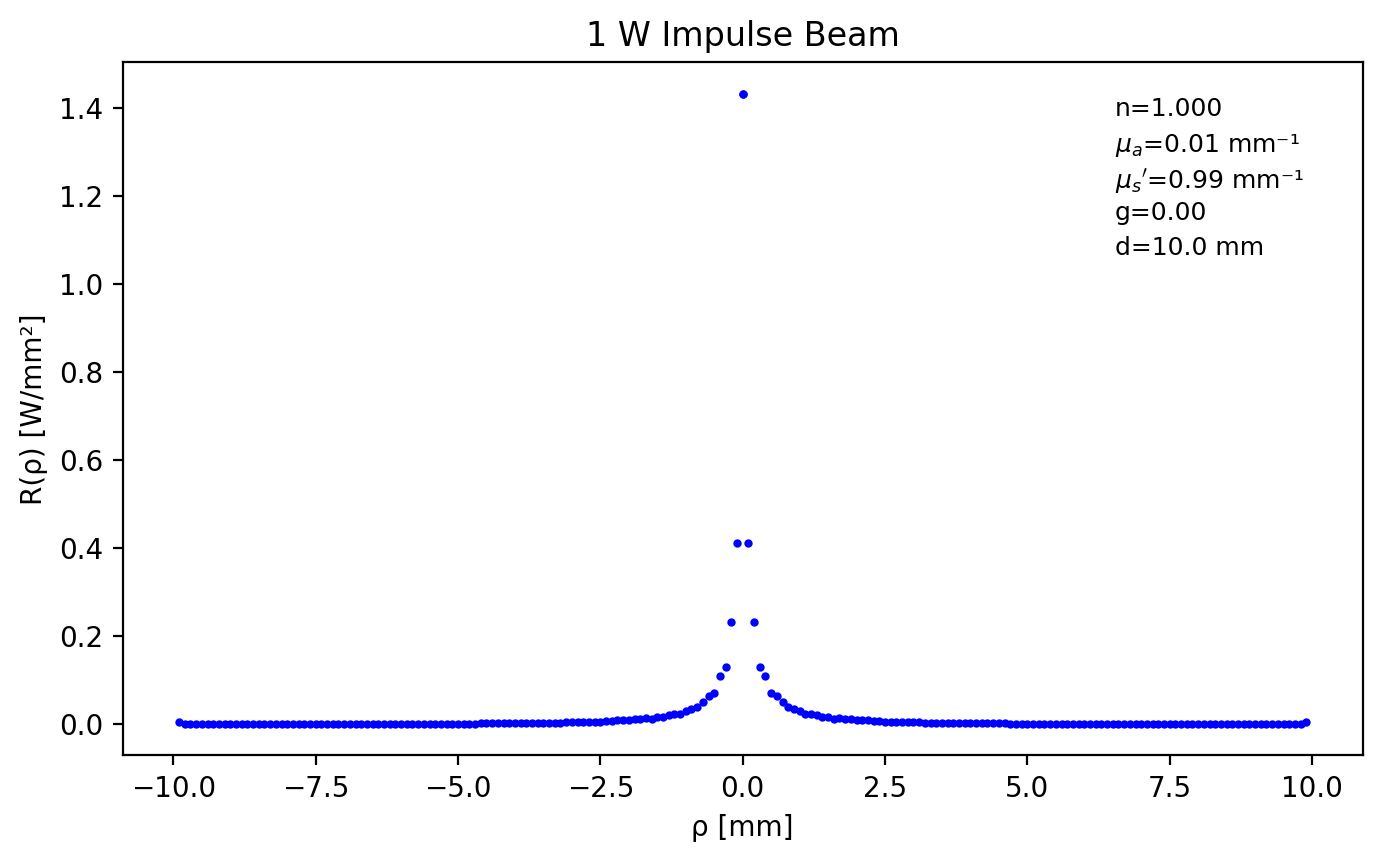

In [9]:
detectorResults = Array.CreateInstance(ROfRhoDetector, 1)
detectorResults[0] = simulationOutput.ResultsDictionary["ROfRho"]

Reflectance = [r for r in detectorResults[0].Mean]
detectorMidpoints = [mp for mp in detectorResults[0].Rho.AsEnumerable()]

r = np.array(detectorMidpoints[:-1])
refl = np.array(Reflectance)

plt.figure(figsize=(8,4.5))
plt.plot(r, refl, 'ob', markersize=2)
plt.plot(-r, refl, 'ob', markersize=2)
plt.xlabel('ρ [mm]')
plt.ylabel('R(ρ) [W/mm²]')
plt.title('1 W Impulse Beam')

text_args = {
    'ha': 'left',  # Horizontal alignment
    'va': 'top',   # Vertical alignment
    'transform': plt.gca().transAxes,  # Coordinate system transformation
    'fontsize': 9  # Font size
}

plt.text(0.8, 0.95, 'n=%.3f' % n, **text_args)
plt.text(0.8, 0.90, r'$\mu_a$=%.2f mm⁻¹' % mua, **text_args)
plt.text(0.8, 0.85, r"${\mu_s}'$=%.2f mm⁻¹" % musp, **text_args)
plt.text(0.8, 0.80, 'g=%.2f' % g, **text_args)
plt.text(0.8, 0.75, 'd=%.1f mm' % d, **text_args)
plt.show()